## CZ4052 Cloud Computing Assignment

### Exploring TCP Algorithm AIMD(Additive Increase Multiplicative Decrease)

The additive-increase/multiplicative-decrease (AIMD) algorithm is a feedback control algorithm best known for its use in TCP congestion control. AIMD combines linear growth of the congestion window when there is no congestion with an exponential reduction when congestion is detected. Multiple flows using AIMD congestion control will eventually converge to an equal usage of a shared link.

The approach taken is to increase the transmission rate (window size), probing for usable bandwidth, until loss occurs. The policy of additive increase may, for instance, increase the congestion window by a fixed amount every round-trip time. When congestion is detected, the transmitter decreases the transmission rate by a multiplicative factor; for example, cut the congestion window in half after loss. The result is a saw-tooth behavior that represents the process of bandwidth probing.

AIMD requires a binary congestion signal. Most frequently, packet loss serves as the signal; the multiplicative decrease is triggered when a timeout or an acknowledgement message indicates a packet lost. It is also possible for in-network switches/routers to mark congestion (without discarding packets) as in Explicit Congestion Notification (ECN).

#### Import Library

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# To make sure repeated random initial cwnd array for every run
np.random.seed(20)

#### Graph Plotting Functions

In [3]:
def visualize_fairness(x,y, max_cwnd_size):
    plt.figure(figsize=(10,6))
    # Set ranges for x and y axes
    plt.xlim(0, max_cwnd_size)
    plt.ylim(0, max_cwnd_size)
    plt.plot(x,y)
    plt.plot([i for i in range(0,max_cwnd_size)], [i for i in range(0,max_cwnd_size)], '--', label='Fairness line') # Plot the dotted line y = x
    plt.plot([max_cwnd_size,0], [0,max_cwnd_size], color='blue',linestyle='--', label = 'Efficiency Line')
    plt.xlabel('User 1 CWND')
    plt.ylabel('User 2 CWND')
    plt.title("User 1 vs User 2 Congestion Window Size")
    plt.legend()
    plt.show()

# Define a function to plot graph of RTT over congestion window size to visualize the changes of CWND over RTT
"""
    Plot graph of RTT over CWND


    Parameter:
    ==========
        num_users: The number of users
        cwnd_tracker: The array of users and its cwnd for each RTT
        plot_title: The title of the graph

    Return Value:
    =============
        The calculated cwnd size of current user
"""
def plot_graph(num_users, cwnd_tracker, plot_title):
    
    plt.figure(figsize=(10, 6))
    for user in range(num_users):
        plt.plot(cwnd_tracker[user], label=f'User {user + 1}')
        
    plt.title(plot_title)    
    plt.xlabel('Round-Trip Time (RTT)')
    plt.ylabel('Congestion Window Size (CWND)')
    
    plt.legend()
    plt.show()

#### Define function used for simulation of AIMD algorithm

In [4]:
# Define the AIMD function that simulates the AIMD behavior for a single user.
"""
    Calculates the AIMD for current user


    Parameter:
    ==========
        user: The index of the current user (unused except for user priority function but included for compatibility).
        alpha: Alpha function for current experiment
        beta: Beta function for current experiment
        cwnd: Current congestion window size.
        status: Status of current congestion window size (Transfer/Drop)

    Return Value:
    =============
        The calculated cwnd size of current user
"""
def AIMD(user, alpha, beta, cwnd, status):
    
    # Additive Increase Phase
    if status == "Transfer":
        cwnd += alpha(user, cwnd)
    # Multiplicative Decrease Phase
    elif status == "Drop":
        cwnd *= beta(user,cwnd)
        # Convert cwnd to integer to avoid fractional values for window sizes.
        cwnd = int(cwnd)  
        # Ensure cwnd does not fall below 1 as there is always something to send by users flow
        cwnd = max(1, cwnd) 
    
    return cwnd

    
# Define the main simulation function.
"""
    Simulation of AIMD process


    Parameter:
    ==========
        no_RTT: The total numbers of Round-Trip Time
        num_users: The total numbers of users
        alpha_func: Alpha function for current experiment
        beta_func: Beta function for current experiment
        initial_cwnd: The array of initial cwnd for all users
        max_cwnd_size: The threshold of congestion window size

    Return Value:
    =============
        The array of users and its cwnd for each RTT
"""
def simulate_aimd(no_RTT, num_users, alpha_func, beta_func, initial_cwnd, max_cwnd_size):
    
    # Initialize the total congestion window size.
    total_cwnd = 0  
    
    # Initialize a tracker for all users flows for congestion window sizes over time.
    cwnd_tracker = np.zeros((num_users, no_RTT))  
    
    
    for i, initial_cwnd_size in enumerate(initial_cwnd):
        cwnd_tracker[i, 0] = initial_cwnd_size
    
    
    for rtt in range(no_RTT):
        
        # Used for tracking total cwnd size for each Round-Trip Time
        cur = 0
        
        # Check if window size exceed the max window size
        if total_cwnd > max_cwnd_size:
            status = "Drop"
            print(f"\n")
            print('(Packet Loss)Multiplicative Decrease at:', rtt)
            cur_peak_cwnd = np.zeros(num_users)
        else:
            status = "Transfer"
            
        
        
        # Loop thru all users flows
        for user in range(num_users):
            
            if status =="Drop":
                cwnd = cwnd_tracker[user, rtt-1]
                print(f"Peak congestion window size for user {user}: {cwnd}")
            # Get cwnd values from prev RTT
            if rtt == 0:
                cwnd = cwnd_tracker[user, 0]
                print(f"Initial cwnd for user {user}: {cwnd}")
            else:
                cwnd = cwnd_tracker[user, rtt-1]
                
            # Perform AIMD
            cwnd = AIMD(user, alpha_func, beta_func, cwnd, status)
            
            # Update current window size for current user
            cwnd_tracker[user, rtt] = cwnd
            cur += cwnd  # Update total cwnd after each user's increase
        total_cwnd = cur
    if len(initial_cwnd)==2:
         visualize_fairness(cwnd_tracker[0],cwnd_tracker[1], max_cwnd_size)
    
    #print(cwnd_tracker)
    
    return cwnd_tracker

#### Define different alpha and beta functions for different experiments later

In [5]:
# Define Alpha Functions
"""
    Calculates the additive increase value for the congestion window


    Parameter:
    ==========
        user: The index of the current user (unused except for user priority function but included for compatibility).
        cwnd: Current congestion window size.

    Return Value:
    =============
        The amount to increase the congestion window size, based on a logarithmic function.
"""
# Define the alpha function for additive increase
def alpha_func(user, cwnd):
    
    # A constant additive increase for all users.
    return 1


# Alpha function with log increase for cwnd
def alpha_func_log(user, cwnd):
    
    BASE = 2 # Base 2 logarithms are taken so that the window size will always be >= 1
    # Make sure cwnd is at least 1 to prevent log(0) 
    cwnd = max(cwnd, 1)
    # As partial window sizes are not allowed, we take the rounded integer value of the window size
    return round(math.log(1 + cwnd, BASE))



# Alpha function with exp increase for cwnd
def alpha_func_exp(user, cwnd):
    
    POWER = 0.5  # Sub-linear growth rate (power < 1)
    # Ensure cwnd is at least 1 to maintain a minimum growth rate
    cwnd = max(cwnd, 1)
    # Calculate the increase as cwnd^POWER and round it to the nearest integer
    increase = round(cwnd ** POWER)
    # Ensure at least a minimum increase of 1 to maintain AIMD properties
    return max(1, increase)



# Define the alpha function with user priority
def alpha_func_priority(user, cwnd):
    
    # Simulating different user priorities depends on the user index
    return 1 + user  



# Define the alpha function with log increase and exp increase based on user priority
def alpha_func_exp_log(user, cwnd):
    
    # Make sure cwnd is at least 1 to prevent log(0) 
    cwnd = max(cwnd, 1)
    
    # Logarithmic increase for the zeroth user
    if user == 0:  
        BASE = 2  # Base of the logarithm
        return max(1, round(math.log(cwnd, BASE)))
    # Exponential increase for the first user
    elif user == 1:  
        POWER = 0.5  # Power for exponential growth, less than 1 for sub-linear growth
        return max(1, round(cwnd ** POWER))

    
    
# Define the beta function for multiplicative decrease
"""
    Calculates the multiplicative decrease value for the congestion window
    
    
    Parameter:
    ==========
        cwnd: The current congestion window size.

    Return Value:
    =============
        The factor by which the cwnd should be multiplied in the multiplicative decrease phase.
"""
def beta_func(user, cwnd):
    
    # A constant multiplicative decrease for all users.
    return 0.5  

def beta_func_low(user, cwnd):
    
    # A constant multiplicative decrease for all users.
    return 0.3

def beta_func_high(user, cwnd):
    
    # A constant multiplicative decrease for all users.
    return 0.8


### Experiment
1. Traditional AIMD
2. AIMD with Logarithmic Incremental function
3. AIMD with Exponential Incremental function
4. AIMD with User Priority
5. AIMD with User Priority Using Logarithmic and Exponential Incremental function

#### Define initial cwnd for 20 users to make it constant among all experiments

In [6]:
# Define the initial cwnd size for users.
max_cwnd = 1000
num_users = 20
initial_cwnd_b = np.random.rand(20)
initial_cwnd_b *= max_cwnd // num_users
initial_cwnd_b = np.round(initial_cwnd_b)

### Experiment 1: AIMD with alpha = 1, beta = 0.5

This is the baseline of our AIMD algorithm

#### Experiment with 2 users

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 31.0
Peak congestion window size for user 1: 71.0


(Packet Loss)Multiplicative Decrease at: 28
Peak congestion window size for user 0: 41.0
Peak congestion window size for user 1: 61.0


(Packet Loss)Multiplicative Decrease at: 55
Peak congestion window size for user 0: 46.0
Peak congestion window size for user 1: 56.0


(Packet Loss)Multiplicative Decrease at: 81
Peak congestion window size for user 0: 48.0
Peak congestion window size for user 1: 53.0


(Packet Loss)Multiplicative Decrease at: 108
Peak congestion window size for user 0: 50.0
Peak congestion window size for user 1: 52.0


(Packet Loss)Multiplicative Decrease at: 134
Peak congestion window size for user 0: 50.0
Peak congestion window size for user 1: 51.0


(Packet Loss)Multiplicative Decrease at: 161
Peak congestion window size for user 0: 51.0
Peak congestion window size for

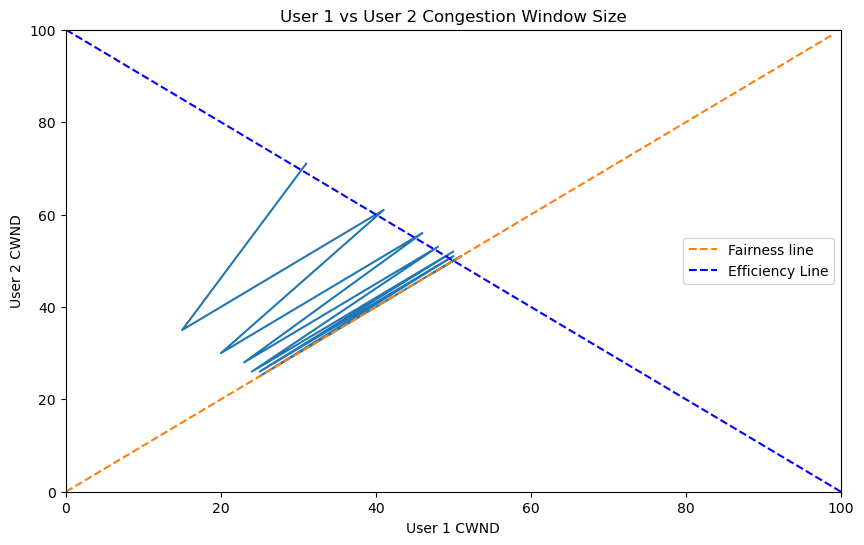

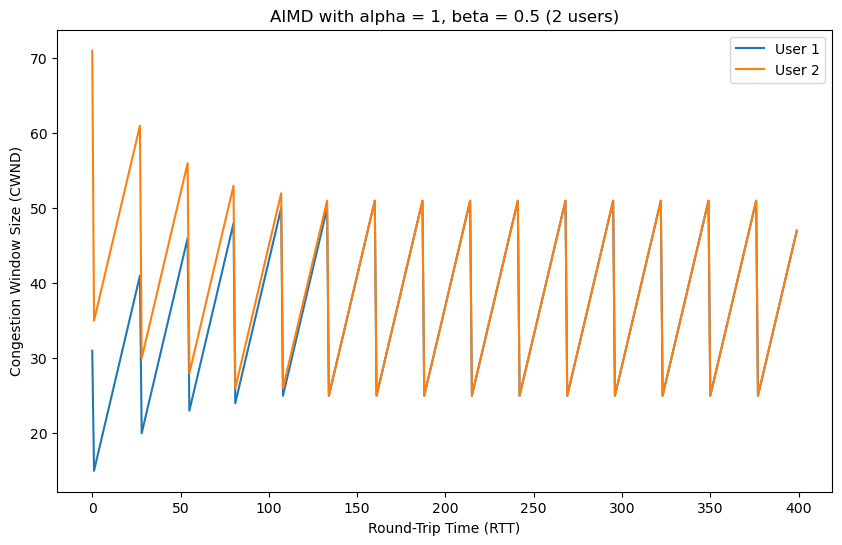

In [7]:
# Experiment Variables
num_users = 2  
max_RTT = 400
max_cwnd = 100  
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with alpha = 1, beta = 0.5 (2 users)"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

Converged at around RTT 161, packet loss count 6



#### Experiment with 2 users (cwnd = 500)

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 201
Peak congestion window size for user 0: 231.0
Peak congestion window size for user 1: 271.0


(Packet Loss)Multiplicative Decrease at: 328
Peak congestion window size for user 0: 241.0
Peak congestion window size for user 1: 261.0


(Packet Loss)Multiplicative Decrease at: 455
Peak congestion window size for user 0: 246.0
Peak congestion window size for user 1: 256.0


(Packet Loss)Multiplicative Decrease at: 581
Peak congestion window size for user 0: 248.0
Peak congestion window size for user 1: 253.0


(Packet Loss)Multiplicative Decrease at: 708
Peak congestion window size for user 0: 250.0
Peak congestion window size for user 1: 252.0


(Packet Loss)Multiplicative Decrease at: 834
Peak congestion window size for user 0: 250.0
Peak congestion window size for user 1: 251.0


(Packet Loss)Multiplicative Decrease at: 961
Peak congestion window size for user 0: 251.0
Peak congesti

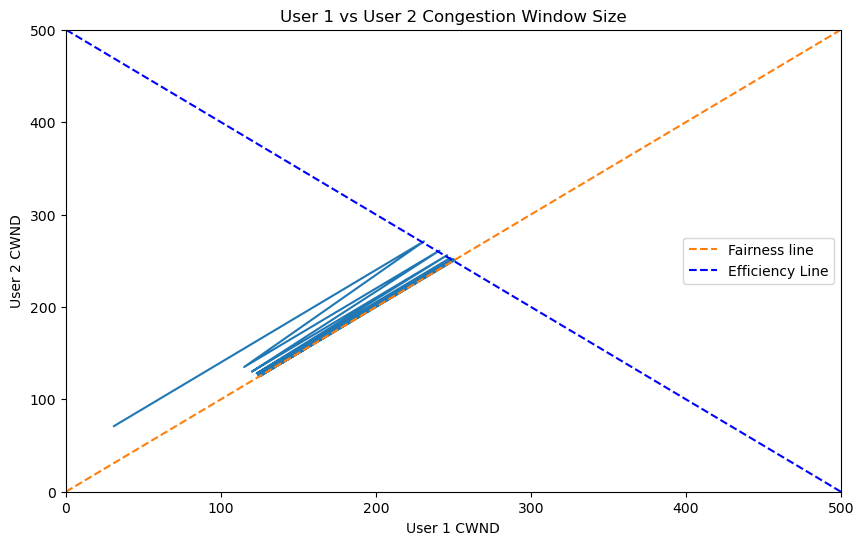

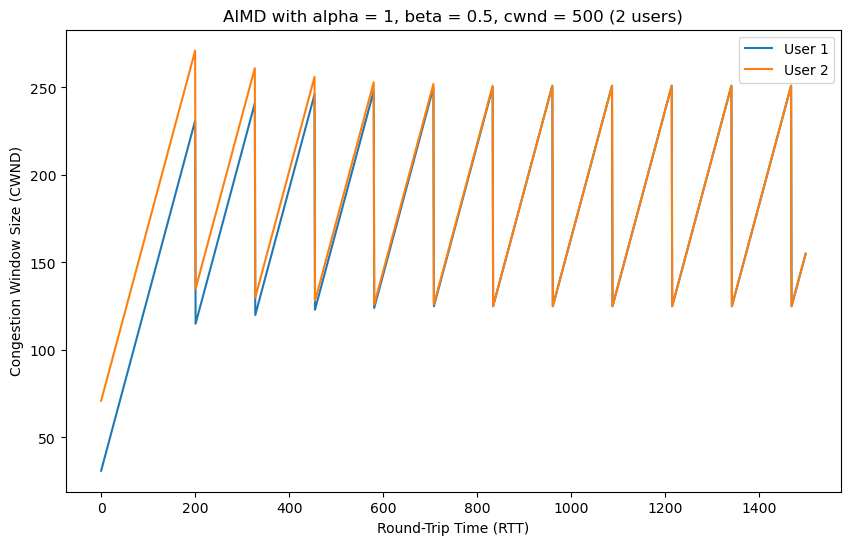

In [8]:
# Experiment Variables
num_users = 2  
max_RTT = 1500  
max_cwnd = 500  
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with alpha = 1, beta = 0.5, cwnd = 500 (2 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:
Converged at 961,Packet loss count 6

#### Experiment with 20 users (cwnd = 500)

Initial cwnd for user 0: 21.0
Initial cwnd for user 1: 24.0
Initial cwnd for user 2: 14.0
Initial cwnd for user 3: 4.0
Initial cwnd for user 4: 19.0
Initial cwnd for user 5: 12.0
Initial cwnd for user 6: 16.0
Initial cwnd for user 7: 21.0
Initial cwnd for user 8: 12.0
Initial cwnd for user 9: 12.0
Initial cwnd for user 10: 17.0
Initial cwnd for user 11: 16.0
Initial cwnd for user 12: 7.0
Initial cwnd for user 13: 2.0
Initial cwnd for user 14: 19.0
Initial cwnd for user 15: 12.0
Initial cwnd for user 16: 8.0
Initial cwnd for user 17: 13.0
Initial cwnd for user 18: 7.0
Initial cwnd for user 19: 8.0


(Packet Loss)Multiplicative Decrease at: 12
Peak congestion window size for user 0: 33.0
Peak congestion window size for user 1: 36.0
Peak congestion window size for user 2: 26.0
Peak congestion window size for user 3: 16.0
Peak congestion window size for user 4: 31.0
Peak congestion window size for user 5: 24.0
Peak congestion window size for user 6: 28.0
Peak congestion window size for use

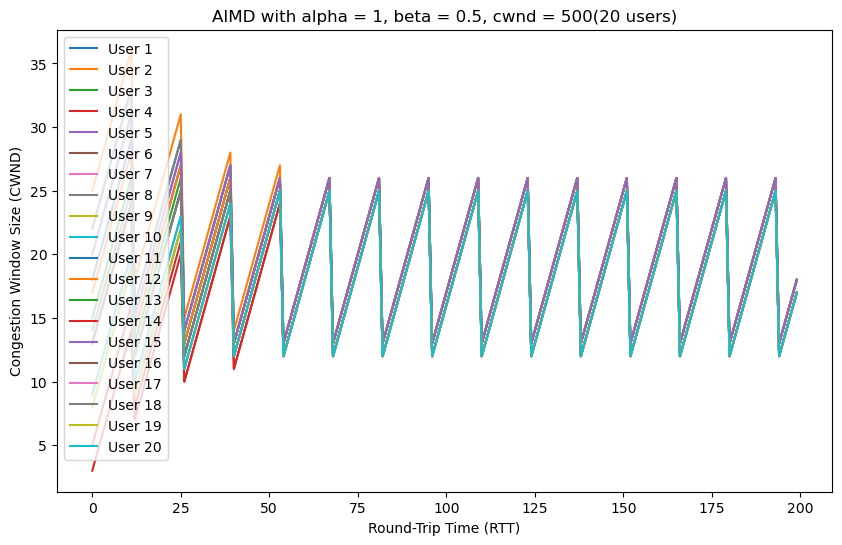

In [9]:
# Experiment Variables
num_users = 20  
max_RTT = 200  
max_cwnd = 500  
# Define the initial cwnd size for users.
initial_cwnd = np.random.rand(20)
initial_cwnd *= max_cwnd // num_users
initial_cwnd = np.round(initial_cwnd)

# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func,initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with alpha = 1, beta = 0.5, cwnd = 500(20 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:
Converged at 68, loss packet count 4

#### Experiment with 20 users (cwnd = 1000)

Initial cwnd for user 0: 29.0
Initial cwnd for user 1: 45.0
Initial cwnd for user 2: 45.0
Initial cwnd for user 3: 41.0
Initial cwnd for user 4: 2.0
Initial cwnd for user 5: 35.0
Initial cwnd for user 6: 19.0
Initial cwnd for user 7: 26.0
Initial cwnd for user 8: 33.0
Initial cwnd for user 9: 10.0
Initial cwnd for user 10: 14.0
Initial cwnd for user 11: 36.0
Initial cwnd for user 12: 39.0
Initial cwnd for user 13: 43.0
Initial cwnd for user 14: 39.0
Initial cwnd for user 15: 2.0
Initial cwnd for user 16: 6.0
Initial cwnd for user 17: 38.0
Initial cwnd for user 18: 12.0
Initial cwnd for user 19: 13.0


(Packet Loss)Multiplicative Decrease at: 24
Peak congestion window size for user 0: 53.0
Peak congestion window size for user 1: 69.0
Peak congestion window size for user 2: 69.0
Peak congestion window size for user 3: 65.0
Peak congestion window size for user 4: 26.0
Peak congestion window size for user 5: 59.0
Peak congestion window size for user 6: 43.0
Peak congestion window size for 

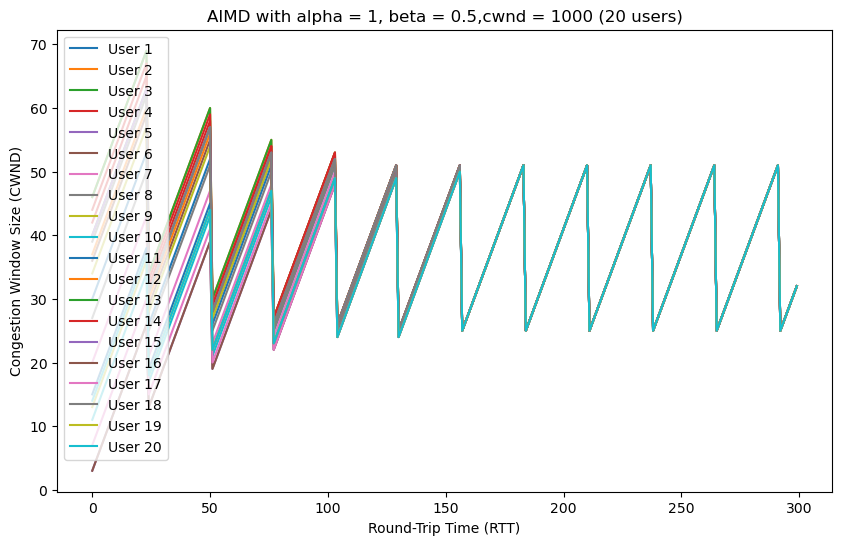

In [10]:
# Experiment Variables
num_users = 20  
max_RTT = 300  
max_cwnd = 1000


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func,initial_cwnd_b, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with alpha = 1, beta = 0.5,cwnd = 1000 (20 users)"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

Converged at 184, Packet loss count 6



### Experiment 2: AIMD with Logarithmic Increase

#### Experiment with 2 users

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 35.0
Peak congestion window size for user 1: 76.0


(Packet Loss)Multiplicative Decrease at: 7
Peak congestion window size for user 0: 40.0
Peak congestion window size for user 1: 66.0


(Packet Loss)Multiplicative Decrease at: 13
Peak congestion window size for user 0: 44.0
Peak congestion window size for user 1: 60.0


(Packet Loss)Multiplicative Decrease at: 19
Peak congestion window size for user 0: 47.0
Peak congestion window size for user 1: 57.0


(Packet Loss)Multiplicative Decrease at: 25
Peak congestion window size for user 0: 48.0
Peak congestion window size for user 1: 54.0


(Packet Loss)Multiplicative Decrease at: 31
Peak congestion window size for user 0: 49.0
Peak congestion window size for user 1: 53.0


(Packet Loss)Multiplicative Decrease at: 37
Peak congestion window size for user 0: 49.0
Peak congestion window size for use

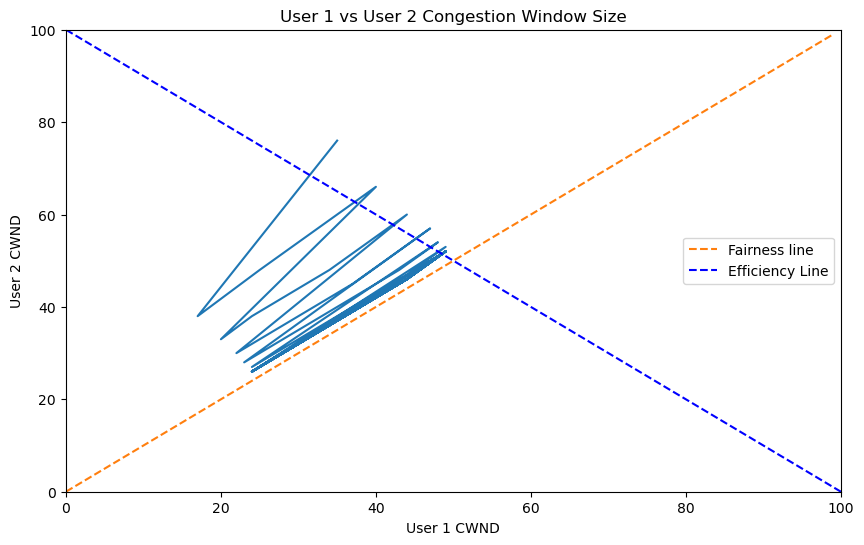

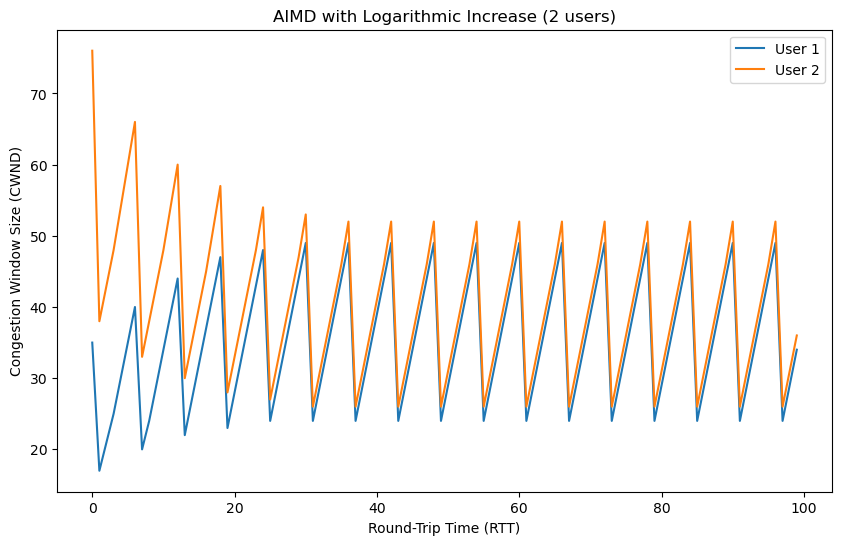

In [11]:
# Experiment Variables
num_users = 2  
max_RTT = 100  
max_cwnd = 100 
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD 
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_log, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Logarithmic Increase (2 users)"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

Converged at 37, Packet loss count 6

We can see that it converges faster as compared to the experiment with 2 users in experiment 1, possible reason is because
that the logarithmic increase function will increase the speed of congestion window to reach its threshold as compared to 
normal alpha increase function, and we can see that due to the higher rate of increase in cwnd size because of log function,
the multiplicative decrease occurs more often compared to experiment 1.



#### Experiment with 20 users

Initial cwnd for user 0: 29.0
Initial cwnd for user 1: 45.0
Initial cwnd for user 2: 45.0
Initial cwnd for user 3: 41.0
Initial cwnd for user 4: 2.0
Initial cwnd for user 5: 35.0
Initial cwnd for user 6: 19.0
Initial cwnd for user 7: 26.0
Initial cwnd for user 8: 33.0
Initial cwnd for user 9: 10.0
Initial cwnd for user 10: 14.0
Initial cwnd for user 11: 36.0
Initial cwnd for user 12: 39.0
Initial cwnd for user 13: 43.0
Initial cwnd for user 14: 39.0
Initial cwnd for user 15: 2.0
Initial cwnd for user 16: 6.0
Initial cwnd for user 17: 38.0
Initial cwnd for user 18: 12.0
Initial cwnd for user 19: 13.0


(Packet Loss)Multiplicative Decrease at: 5
Peak congestion window size for user 0: 55.0
Peak congestion window size for user 1: 75.0
Peak congestion window size for user 2: 75.0
Peak congestion window size for user 3: 70.0
Peak congestion window size for user 4: 16.0
Peak congestion window size for user 5: 63.0
Peak congestion window size for user 6: 43.0
Peak congestion window size for u

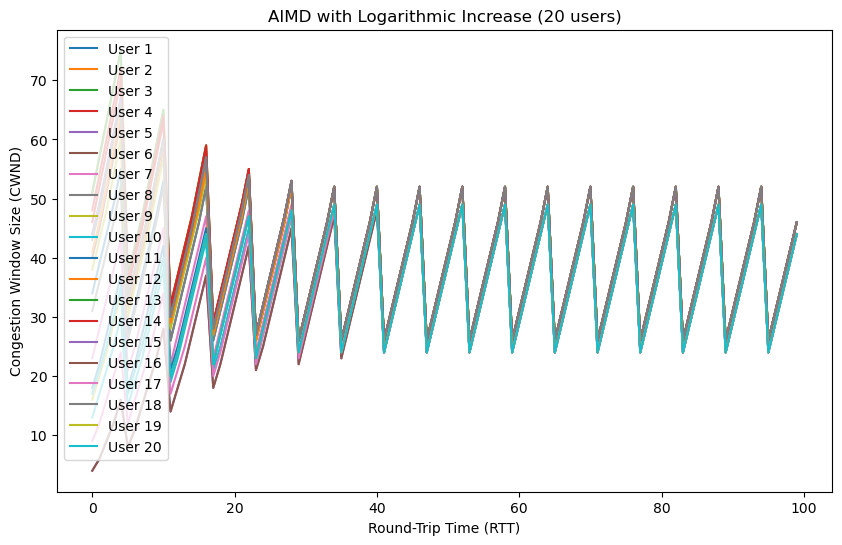

In [12]:
# Experiment Variables
num_users = 20  
max_RTT = 100  
max_cwnd = 1000  



# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_log, beta_func, initial_cwnd_b, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Logarithmic Increase (20 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:
Converge at RTT 47, Packet loss count 7

### Experiment 3: AIMD with Exponential Increase

#### Experiment with 2 users

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 35.0
Peak congestion window size for user 1: 78.0


(Packet Loss)Multiplicative Decrease at: 6
Peak congestion window size for user 0: 37.0
Peak congestion window size for user 1: 67.0


(Packet Loss)Multiplicative Decrease at: 12
Peak congestion window size for user 0: 44.0
Peak congestion window size for user 1: 67.0


(Packet Loss)Multiplicative Decrease at: 17
Peak congestion window size for user 0: 44.0
Peak congestion window size for user 1: 59.0


(Packet Loss)Multiplicative Decrease at: 23
Peak congestion window size for user 0: 51.0
Peak congestion window size for user 1: 60.0


(Packet Loss)Multiplicative Decrease at: 28
Peak congestion window size for user 0: 47.0
Peak congestion window size for user 1: 54.0


(Packet Loss)Multiplicative Decrease at: 34
Peak congestion window size for user 0: 52.0
Peak congestion window size for use

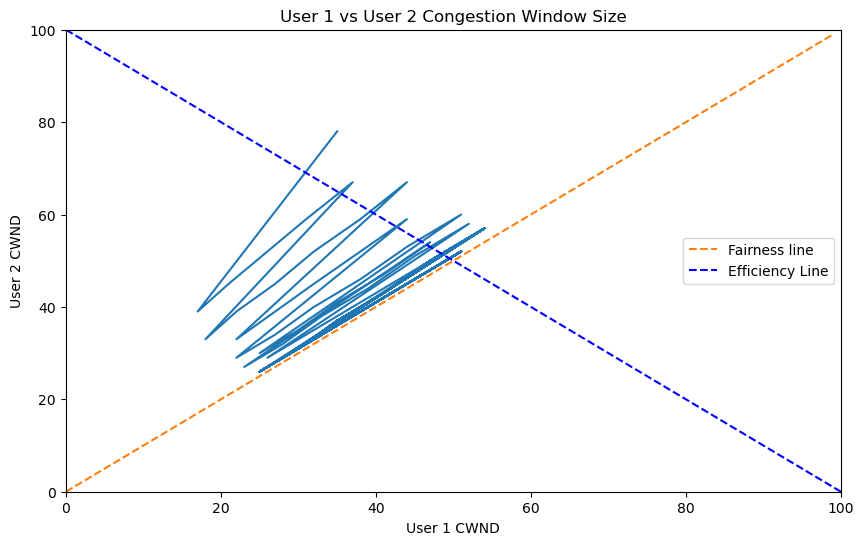

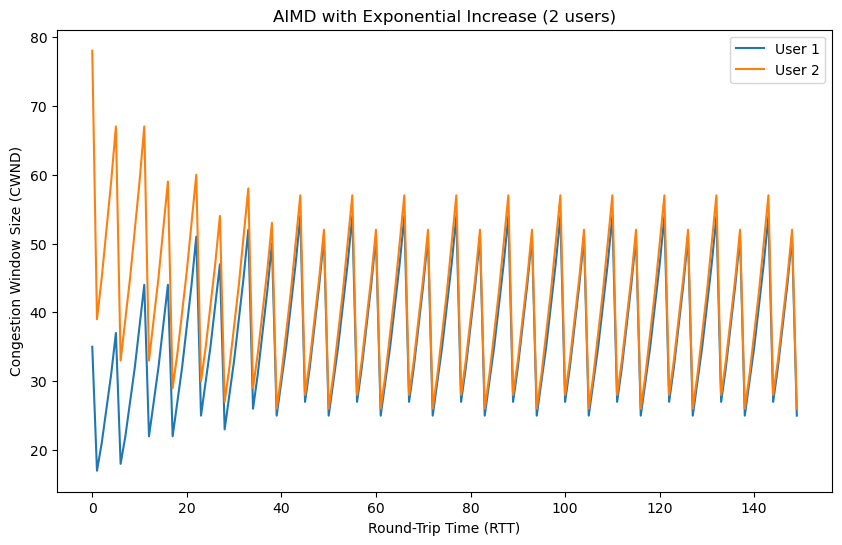

In [13]:
# Experiment Variables
num_users = 2  
max_RTT = 150  
max_cwnd = 100  
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_exp, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Exponential Increase (2 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:

Converged at 45, Packet loss count 8

We can see that it converges slightly slower as compared to logarithmic increase function, however we can see that after
it converges, we will have a lower peak and higher peak for every 2 peaks, possible reason is because that the higher rate
of increase in cwnd size compared to logarithmic increase function and because of the lower cwnd size.



#### Experiment with 2 users (cwnd = 200)

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 7
Peak congestion window size for user 0: 77.0
Peak congestion window size for user 1: 138.0


(Packet Loss)Multiplicative Decrease at: 14
Peak congestion window size for user 0: 83.0
Peak congestion window size for user 1: 126.0


(Packet Loss)Multiplicative Decrease at: 21
Peak congestion window size for user 0: 86.0
Peak congestion window size for user 1: 117.0


(Packet Loss)Multiplicative Decrease at: 28
Peak congestion window size for user 0: 91.0
Peak congestion window size for user 1: 112.0


(Packet Loss)Multiplicative Decrease at: 36
Peak congestion window size for user 0: 103.0
Peak congestion window size for user 1: 117.0


(Packet Loss)Multiplicative Decrease at: 43
Peak congestion window size for user 0: 102.0
Peak congestion window size for user 1: 112.0


(Packet Loss)Multiplicative Decrease at: 50
Peak congestion window size for user 0: 102.0
Peak congestion window si

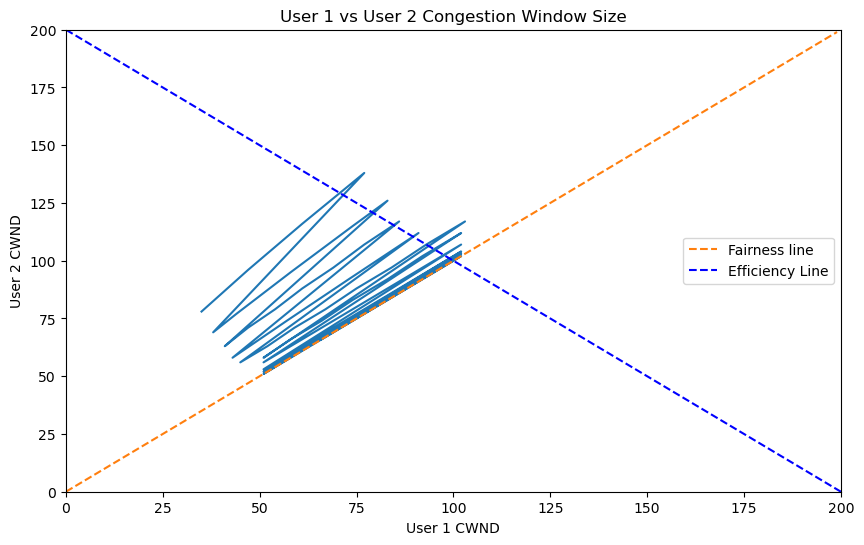

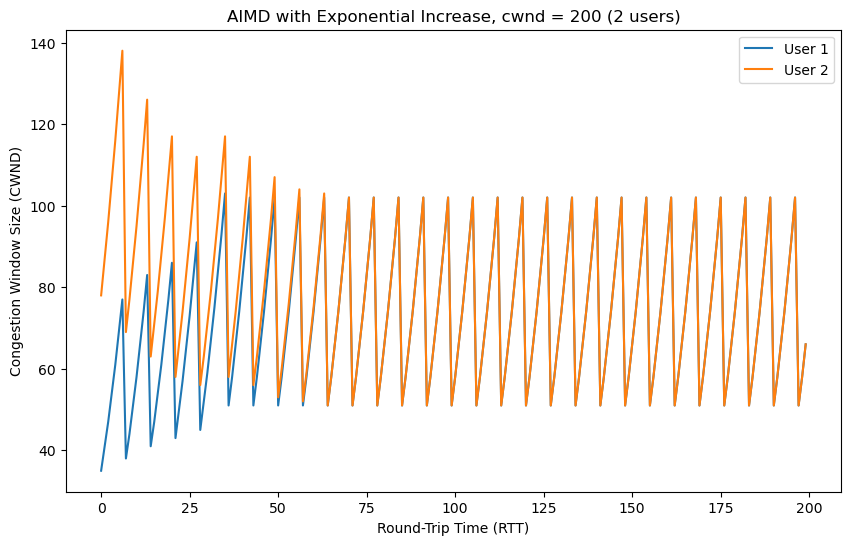

In [14]:
# Experiment Variables
num_users = 2  
max_RTT = 200  
max_cwnd = 200  
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_exp, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Exponential Increase, cwnd = 200 (2 users)"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

Converged at RTT 71, packet loss count 9

We can see that this proves our reason in the previous experiment, as now when cwnd size has increase, after the cwnd
has converged, we will not have a low and high peak in the graph



#### Experiment with 20 users

Initial cwnd for user 0: 29.0
Initial cwnd for user 1: 45.0
Initial cwnd for user 2: 45.0
Initial cwnd for user 3: 41.0
Initial cwnd for user 4: 2.0
Initial cwnd for user 5: 35.0
Initial cwnd for user 6: 19.0
Initial cwnd for user 7: 26.0
Initial cwnd for user 8: 33.0
Initial cwnd for user 9: 10.0
Initial cwnd for user 10: 14.0
Initial cwnd for user 11: 36.0
Initial cwnd for user 12: 39.0
Initial cwnd for user 13: 43.0
Initial cwnd for user 14: 39.0
Initial cwnd for user 15: 2.0
Initial cwnd for user 16: 6.0
Initial cwnd for user 17: 38.0
Initial cwnd for user 18: 12.0
Initial cwnd for user 19: 13.0


(Packet Loss)Multiplicative Decrease at: 5
Peak congestion window size for user 0: 60.0
Peak congestion window size for user 1: 84.0
Peak congestion window size for user 2: 84.0
Peak congestion window size for user 3: 77.0
Peak congestion window size for user 4: 13.0
Peak congestion window size for user 5: 69.0
Peak congestion window size for user 6: 45.0
Peak congestion window size for u

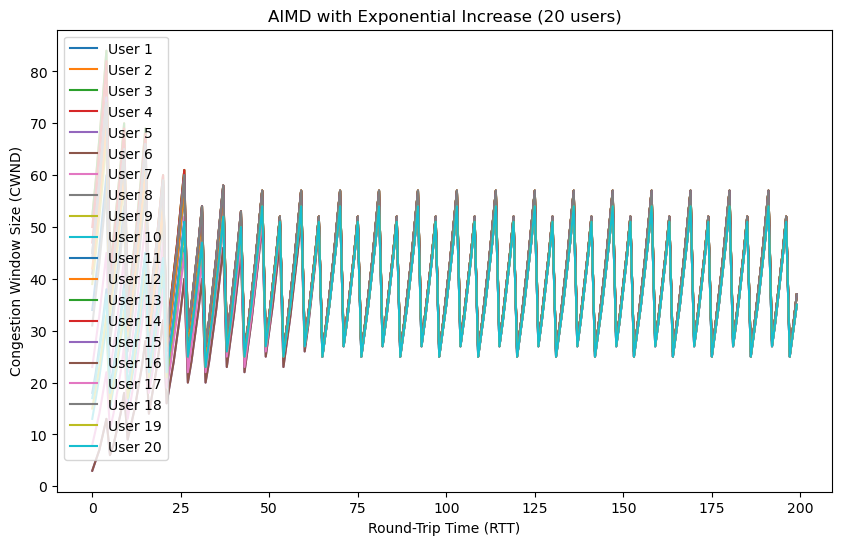

In [15]:
# Experiment Variables
num_users = 20  
max_RTT = 200  
max_cwnd = 1000

# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_exp, beta_func, initial_cwnd_b, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Exponential Increase (20 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:
Converged at RTT 49, Packet loss count 8

#### Experiment with 20 users (cwnd = 2000)

Initial cwnd for user 0: 63.0
Initial cwnd for user 1: 56.0
Initial cwnd for user 2: 32.0
Initial cwnd for user 3: 39.0
Initial cwnd for user 4: 26.0
Initial cwnd for user 5: 58.0
Initial cwnd for user 6: 16.0
Initial cwnd for user 7: 60.0
Initial cwnd for user 8: 83.0
Initial cwnd for user 9: 16.0
Initial cwnd for user 10: 73.0
Initial cwnd for user 11: 41.0
Initial cwnd for user 12: 78.0
Initial cwnd for user 13: 80.0
Initial cwnd for user 14: 79.0
Initial cwnd for user 15: 59.0
Initial cwnd for user 16: 66.0
Initial cwnd for user 17: 65.0
Initial cwnd for user 18: 43.0
Initial cwnd for user 19: 51.0


(Packet Loss)Multiplicative Decrease at: 6
Peak congestion window size for user 0: 117.0
Peak congestion window size for user 1: 107.0
Peak congestion window size for user 2: 74.0
Peak congestion window size for user 3: 84.0
Peak congestion window size for user 4: 65.0
Peak congestion window size for user 5: 112.0
Peak congestion window size for user 6: 46.0
Peak congestion window size

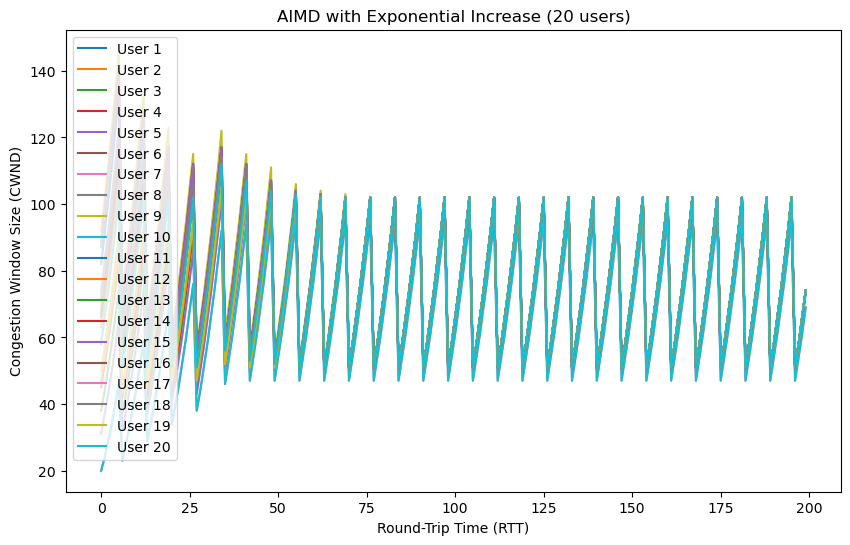

In [16]:
# Experiment Variables
num_users = 20  
max_RTT = 200  
max_cwnd = 2000  
# Define the initial cwnd size for users.
initial_cwnd = np.random.rand(20)
initial_cwnd *= max_cwnd // num_users
initial_cwnd = np.round(initial_cwnd)

# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_exp, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with Exponential Increase (20 users)"
plot_graph(num_users, cwnd_tracker, plot_title)

##### Observation:
Converged at RTT 77, Packet loss count 10

### Experiment 4: AIMD with User Priority

In this experiment, we differentiate user priorities by modifying the alpha function. Each user's alpha value depends on their index, which results in one user's cwnd grows faster than the other's, simulating a priority system.For consistency, user 2 is the premium user tier and thus has a larger share of the network bandwidth, compared to user 1.

#### Experiment with different alpha values (30,70)

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 31.0
Peak congestion window size for user 1: 72.0


(Packet Loss)Multiplicative Decrease at: 19
Peak congestion window size for user 0: 32.0
Peak congestion window size for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 37
Peak congestion window size for user 0: 33.0
Peak congestion window size for user 1: 69.0


(Packet Loss)Multiplicative Decrease at: 55
Peak congestion window size for user 0: 33.0
Peak congestion window size for user 1: 68.0


(Packet Loss)Multiplicative Decrease at: 73
Peak congestion window size for user 0: 33.0
Peak congestion window size for user 1: 68.0


(Packet Loss)Multiplicative Decrease at: 91
Peak congestion window size for user 0: 33.0
Peak congestion window size for user 1: 68.0


(Packet Loss)Multiplicative Decrease at: 109
Peak congestion window size for user 0: 33.0
Peak congestion window size for u

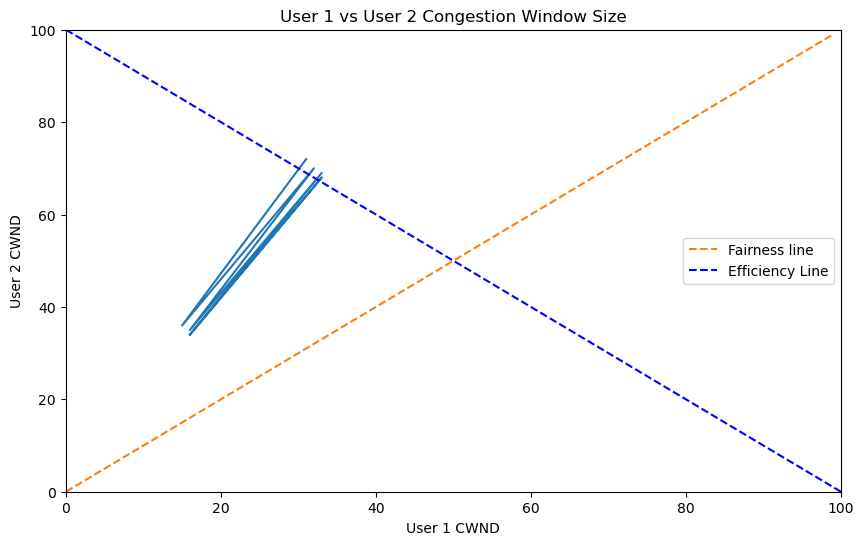

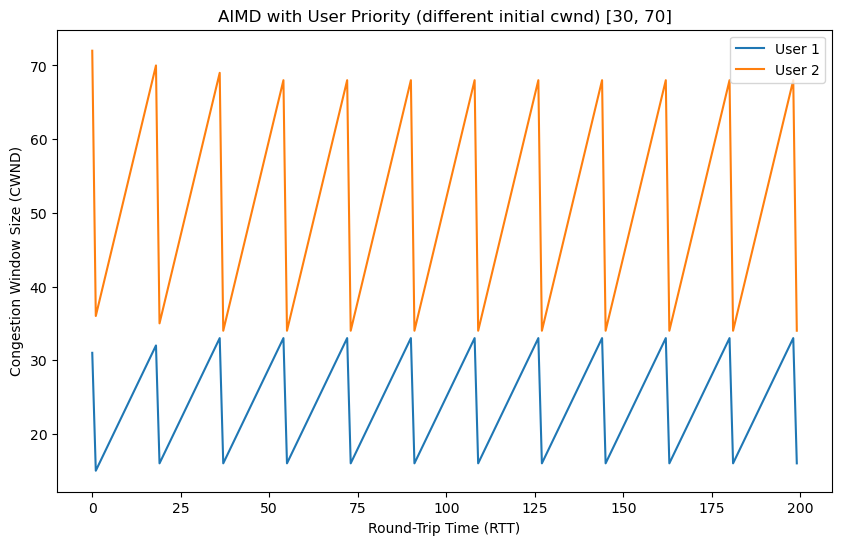

In [17]:
# Experiment Variables
num_users = 2  
max_RTT = 200  
max_cwnd = 100 
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_priority, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with User Priority (different initial cwnd) [30, 70]"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

The AIMD converge at around RTT 55, Packet loss count 3

We can see that in this experiment the zig-zag line of user 1 is not aligned with user 2 as compared to the experiment 1,
this is because that we implemented user priority in this experiment and for each users we will have different increase value
for additive increase phase.
This experiment converges faster as compared to experiment 1, possible reason might be due to the implementation 
of alpha function, we implemented it by adding the user index which increase the rate of increase of cwnd size hence it will
converges slightly faster.



#### Experiment with different alpha values (70,30)

Initial cwnd for user 0: 70.0
Initial cwnd for user 1: 30.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 71.0
Peak congestion window size for user 1: 32.0


(Packet Loss)Multiplicative Decrease at: 19
Peak congestion window size for user 0: 52.0
Peak congestion window size for user 1: 50.0


(Packet Loss)Multiplicative Decrease at: 37
Peak congestion window size for user 0: 43.0
Peak congestion window size for user 1: 59.0


(Packet Loss)Multiplicative Decrease at: 55
Peak congestion window size for user 0: 38.0
Peak congestion window size for user 1: 63.0


(Packet Loss)Multiplicative Decrease at: 73
Peak congestion window size for user 0: 36.0
Peak congestion window size for user 1: 65.0


(Packet Loss)Multiplicative Decrease at: 91
Peak congestion window size for user 0: 35.0
Peak congestion window size for user 1: 66.0


(Packet Loss)Multiplicative Decrease at: 109
Peak congestion window size for user 0: 34.0
Peak congestion window size for u

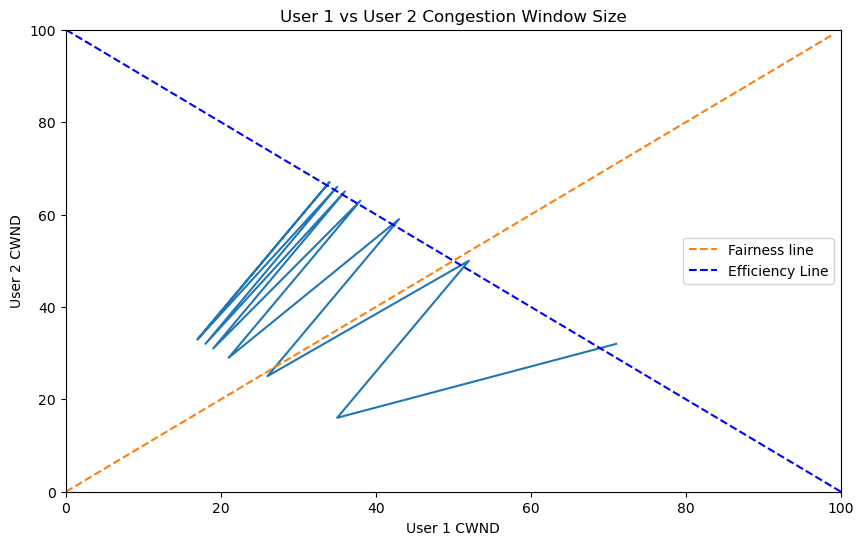

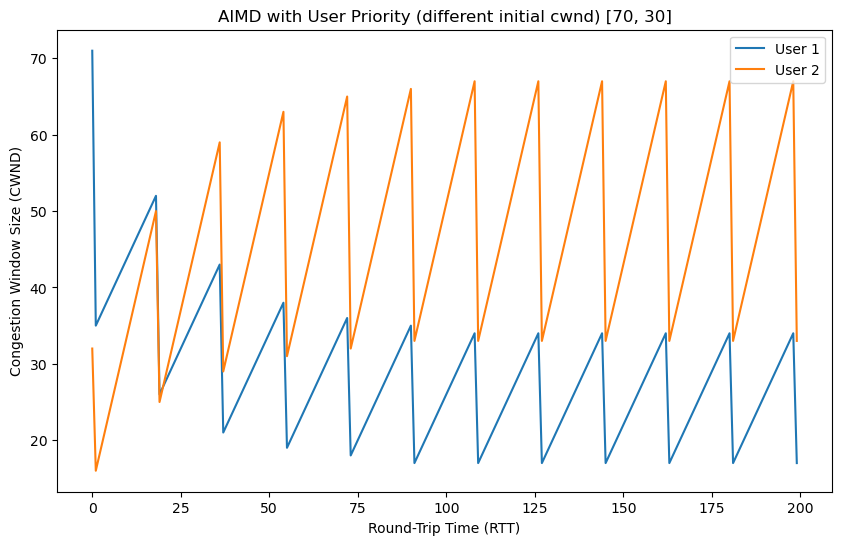

In [18]:
# Experiment Variables
num_users = 2  
max_RTT = 200  
max_cwnd = 100  
# Define the initial cwnd size for users.
initial_cwnd = [70, 30] 


# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func_priority, beta_func, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with User Priority (different initial cwnd) [70, 30]"
plot_graph(num_users, cwnd_tracker, plot_title)


##### Observation:

Converged at around RTT 109, packet loss count 6

We can see that it converges slightly slower as compared to previous experiment, this is because that the priority of 
user 1 is lower than user 2 but the initial cwnd size of user 1 is higher than user 2, hence it slows down the convergence
time of the congestion window size.




#### Approach by modifying beta functions (30,70)

Initial cwnd for user 0: 30.0
Initial cwnd for user 1: 70.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 31.0
Peak congestion window size for user 1: 71.0


(Packet Loss)Multiplicative Decrease at: 27
Peak congestion window size for user 0: 34.0
Peak congestion window size for user 1: 67.0


(Packet Loss)Multiplicative Decrease at: 54
Peak congestion window size for user 0: 36.0
Peak congestion window size for user 1: 66.0


(Packet Loss)Multiplicative Decrease at: 81
Peak congestion window size for user 0: 36.0
Peak congestion window size for user 1: 65.0


(Packet Loss)Multiplicative Decrease at: 108
Peak congestion window size for user 0: 36.0
Peak congestion window size for user 1: 65.0


(Packet Loss)Multiplicative Decrease at: 135
Peak congestion window size for user 0: 36.0
Peak congestion window size for user 1: 65.0


(Packet Loss)Multiplicative Decrease at: 162
Peak congestion window size for user 0: 36.0
Peak congestion window size for

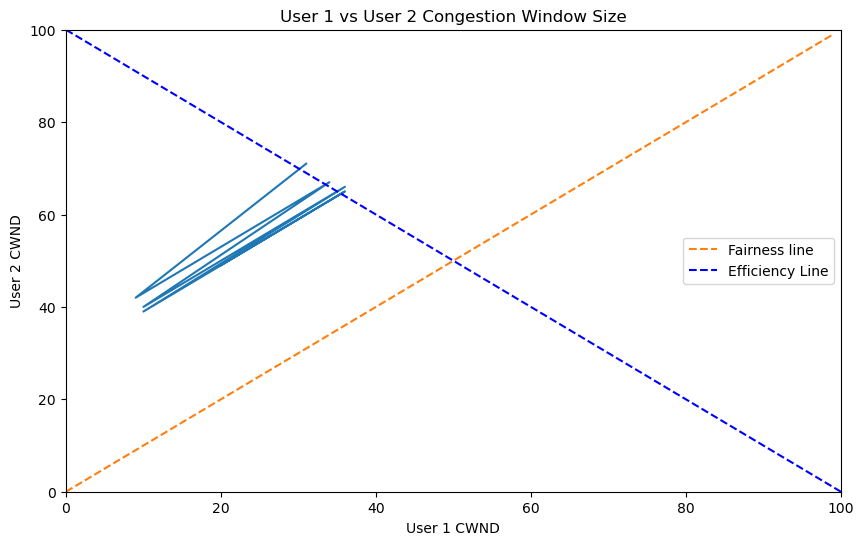

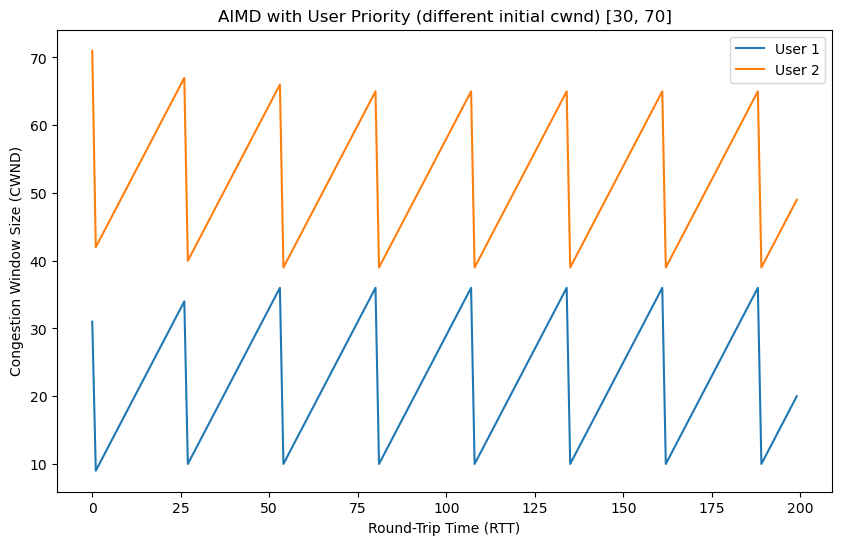

In [19]:
# Experiment Variables
num_users = 2  
max_RTT = 200  
max_cwnd = 100  
# Define the initial cwnd size for users.
initial_cwnd = [30, 70] 

def beta_func_priority(user,cwnd):
    
    # A constant multiplicative decrease for all users.
    if user == 0:
        return 0.3
    else:
        return 0.6
    

# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func_priority, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with User Priority (different initial cwnd) [30, 70]"
plot_graph(num_users, cwnd_tracker, plot_title)

#### Approach by modifying beta functions (70,30)

Initial cwnd for user 0: 70.0
Initial cwnd for user 1: 30.0


(Packet Loss)Multiplicative Decrease at: 1
Peak congestion window size for user 0: 71.0
Peak congestion window size for user 1: 31.0


(Packet Loss)Multiplicative Decrease at: 33
Peak congestion window size for user 0: 52.0
Peak congestion window size for user 1: 49.0


(Packet Loss)Multiplicative Decrease at: 63
Peak congestion window size for user 0: 44.0
Peak congestion window size for user 1: 58.0


(Packet Loss)Multiplicative Decrease at: 91
Peak congestion window size for user 0: 40.0
Peak congestion window size for user 1: 61.0


(Packet Loss)Multiplicative Decrease at: 119
Peak congestion window size for user 0: 39.0
Peak congestion window size for user 1: 63.0


(Packet Loss)Multiplicative Decrease at: 147
Peak congestion window size for user 0: 38.0
Peak congestion window size for user 1: 64.0


(Packet Loss)Multiplicative Decrease at: 174
Peak congestion window size for user 0: 37.0
Peak congestion window size for

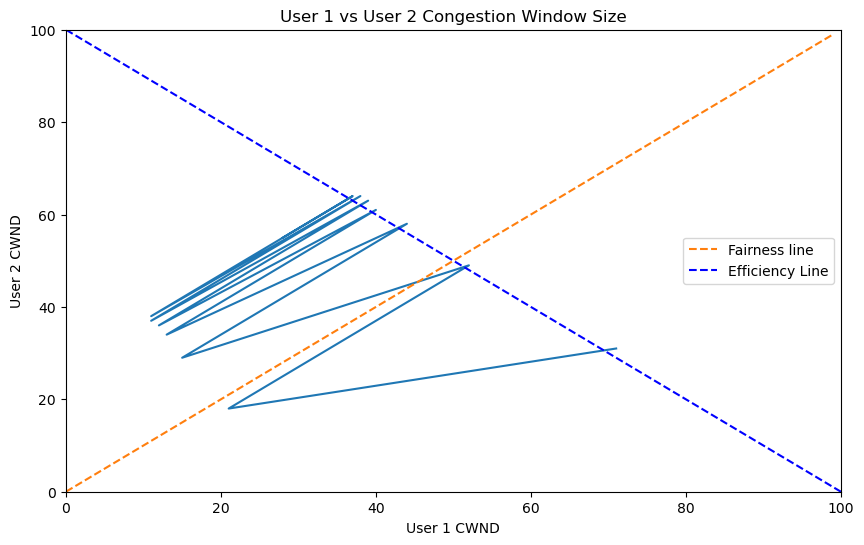

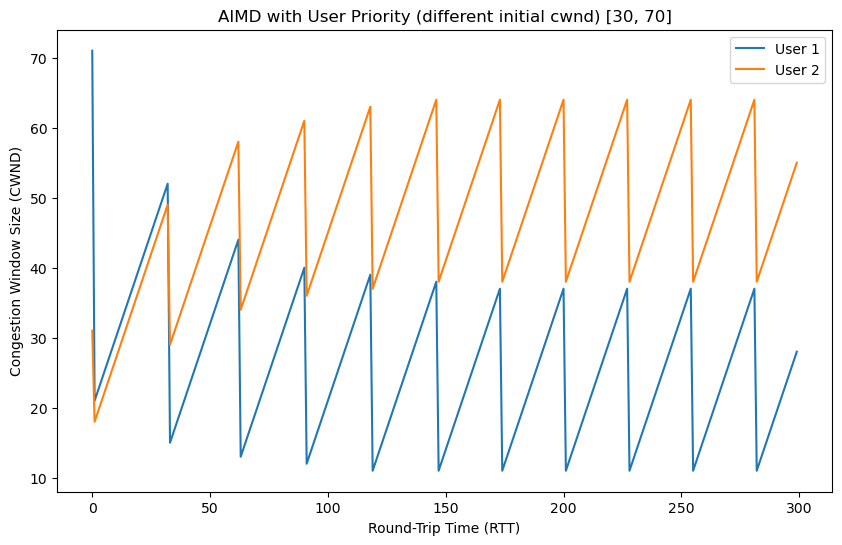

In [20]:
# Experiment Variables
num_users = 2  
max_RTT = 300  
max_cwnd = 100  
# Define the initial cwnd size for users.
initial_cwnd = [70, 30] 

def beta_func_priority(user,cwnd):
    
    # A constant multiplicative decrease for all users.
    if user == 0:
        return 0.3
    else:
        return 0.6
    

# Simulation of AIMD
cwnd_tracker = simulate_aimd(max_RTT, num_users, alpha_func, beta_func_priority, initial_cwnd, max_cwnd)

# Plot graph of RTT over CWND
plot_title = "AIMD with User Priority (different initial cwnd) [30, 70]"
plot_graph(num_users, cwnd_tracker, plot_title)